In [ ]:
# Calculate the global (both area-weighted and not weighted) annual mean temperature in Celsius (TA) from 1990 to 2020

import urllib.request
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np


# Download the data
url = f"https://downloads.psl.noaa.gov/Datasets/ghcncams/air.mon.mean.nc"
savename = url.split("/")[-1]
urllib.request.urlretrieve(url, savename)

# Open the air temprature dataset and save air temp data
ds = xr.open_dataset(savename)
air = ds["air"]
#print(air) monthly mean surface temp, units are in degrees

# convert degrees to celsius
air = ds.air - 273.15

# Find global unweighted annual average (average over all lat and lon)
annual = air.mean(("lon", "lat"))
annual_unweighted = annual.groupby("time.year").mean()

# Select data from 1990-2020
annual_mean_unweighted = annual_unweighted.sel(year=slice("1990-01-01", "2020-12-31"))


#Create weights
weights = np.cos(np.deg2rad(air.lat))
weights.name = "weights"
weighted = air.weighted(weights)

#Find mean
weighted_mean = weighted.mean(("lon", "lat"))

# Go from monthly mean to yearly mean
weighted_annual = weighted_mean.groupby('time.year').mean()

# Take subset to get 1990 to 2020
weighted_annual_subset = weighted_annual.where((weighted_annual.year > 1990) & (weighted_annual.year < 2021), drop=True)

print(weighted_annual_subset)
print(annual_mean_unweighted)


<xarray.DataArray 'air' (year: 30)> Size: 240B
array([13.59981537, 13.29656219, 13.38782501, 13.55515671, 13.88332081,
       13.46063995, 13.72594547, 14.11997509, 13.86964417, 13.76299191,
       13.99203205, 14.09715939, 14.09807205, 13.9353714 , 14.24123287,
       14.12703609, 14.2353363 , 13.99539566, 14.04430389, 14.31394958,
       14.0491457 , 14.10944366, 14.17205811, 14.24660397, 14.56562805,
       14.69768143, 14.54633999, 14.32727909, 14.66214085, 14.75998783])
Coordinates:
  * year     (year) int64 240B 1991 1992 1993 1994 1995 ... 2017 2018 2019 2020
<xarray.DataArray 'air' (year: 30)> Size: 240B
array([ 8.71488094,  8.32298946,  8.49985695,  8.62871265,  9.09751701,
        8.57421589,  8.85487461,  9.19190884,  8.96420097,  8.92756557,
        9.13376999,  9.23797131,  9.29805088,  8.99719334,  9.48242855,
        9.32206249,  9.4698267 ,  9.20330906,  9.14826965,  9.51652908,
        9.31947041,  9.31527138,  9.30993557,  9.40820026,  9.7103014 ,
        9.97964191, 

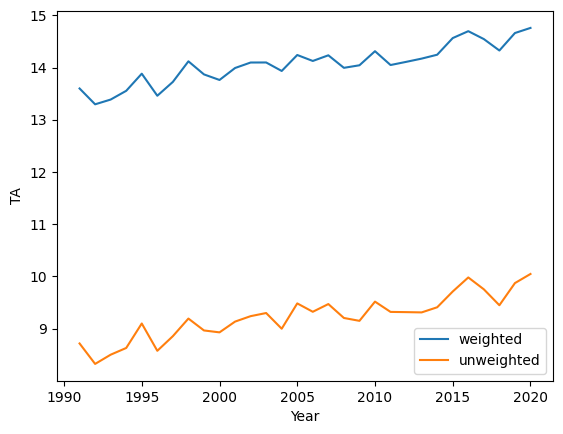

In [ ]:
# Plot weighted and unweighted annual mean
weighted_annual_subset.plot(label="weighted")
annual_mean_unweighted.plot(label="unweighted")
plt.xlabel("Year")
plt.ylabel("TA")
plt.legend()


<xarray.DataArray 'air' (lat: 360, lon: 720)> Size: 1MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * lat      (lat) float32 1kB 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * lon      (lon) float32 3kB 0.25 0.75 1.25 1.75 ... 358.2 358.8 359.2 359.8


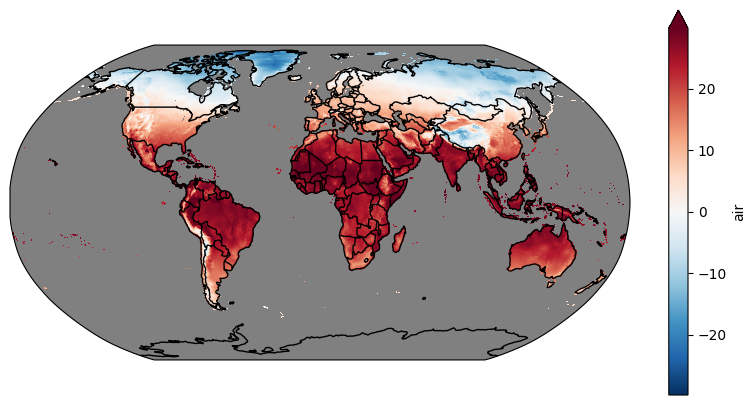

In [21]:
# Visualize with robinson projection

#!pip install cartopy geoviews hvplot

import cartopy.crs as ccrs
import cartopy.feature as cfeature

annual_unweighted = air.groupby("time.year").mean() #take mean of year for all lat and lon
annual_mean_unweighted = annual_unweighted.sel(year=slice("1990-01-01", "2020-12-31")) #get 1990 to 2020
total_mean_unweighted = annual_mean_unweighted.mean("year") #find mean over all year
print(total_mean_unweighted)

p = total_mean_unweighted.isel(lat=range(0,360), lon=range(0,720)).plot(
    subplot_kws=dict(projection=ccrs.Robinson(), facecolor="gray"),
    figsize=(10, 5),
    transform=ccrs.PlateCarree(),
    robust=True,
)

p.axes.coastlines()
p.axes.add_feature(cfeature.BORDERS)
